In [1]:
"""
Current objective are :
1. To construct a simple cuboid mesh and visualize the respective cuboid
2. To construct envelope for a simple building
    a. Take a single from some data.
    b. Construct the cuboid (LOD1.0)
3. Future : Extract footprint and construct an LOD1.2 mesh
"""

'\nCurrent objective are :\n1. To construct a simple cuboid mesh and visualize the respective cuboid\n2. To construct envelope for a simple building\n    a. Take a single from some data.\n    b. Construct the cuboid (LOD1.0)\n3. Future : Extract footprint and construct an LOD1.2 mesh\n'

### **1. Contructing simple cuboid**

In [1]:
import pyvista as pv
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
vertices = np.array([
    [0, 0, 0],  # 0
    [3, 0, 0],  # 1 This
    [3, 1, 0],  # 2 This
    [0, 1, 0],  # 3
    [0, 0, 1],  # 4
    [3, 0, 1],  # 5 This
    [3, 1, 1],  # 6 This
    [0, 1, 1]   # 7
])

#### **Faces definition :**

General representation : [N, v1, v2, v3, v4, ...]
Vertices are selected in the order of initialization (**Check the indices in the vertices list**)

In [3]:
faces = np.array([
    [4, 0, 1, 2, 3],  # Bottom face
    [4, 4, 5, 6, 7],  # Top face
    [4, 0, 1, 5, 4],  # Front face
    [4, 1, 2, 6, 5],  # Right face
    [4, 2, 3, 7, 6],  # Back face
    [4, 3, 0, 4, 7]   # Left face
])

In [ ]:
mesh = pv.PolyData(vertices, faces) #This will generate the mesh

In [6]:
mesh.save("cube.ply")

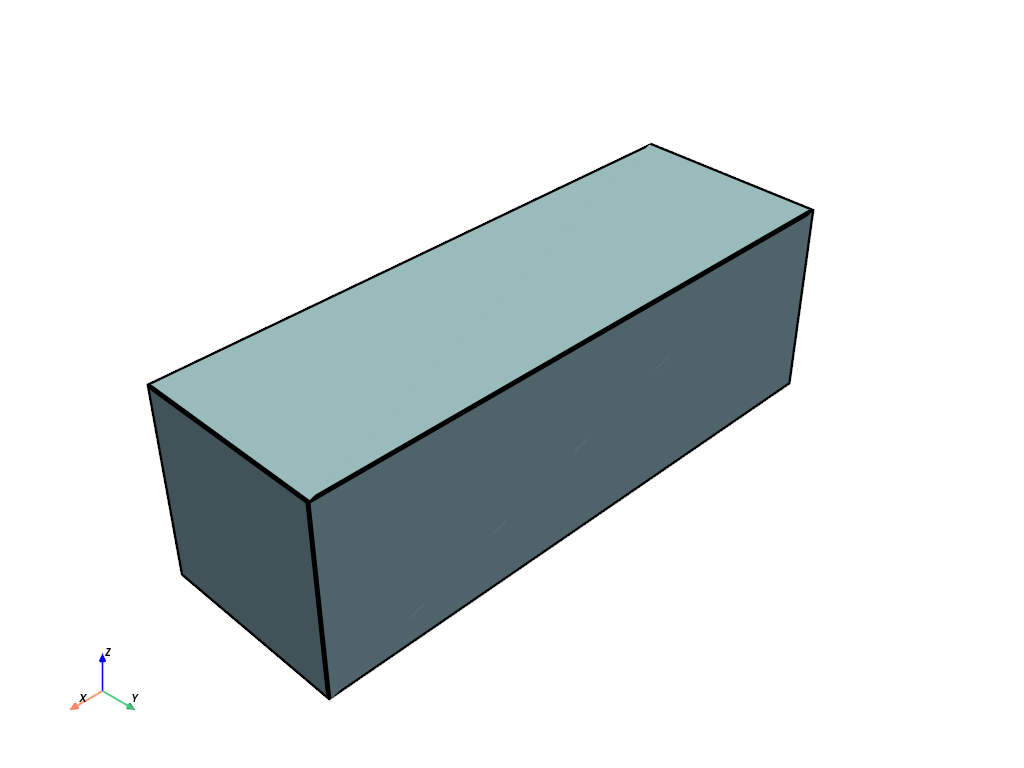

In [5]:
mesh.plot(show_edges=True, line_width=5)

## **2. Construction of LOD1**

### **2.1 Contructing simple cuboid**
Based on maximum points along xyz axis

In [8]:
import pyvista as pv
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [9]:
#------------------------------------------------------------------------------------------<Load PLY>---------------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    points = np.array(cloud.points)
    return points

plyFile = "InputOutput/Building_2_Label2.ply"
pointCloud = loadPC(plyFile)

pointCloudMesh = pv.PolyData(pointCloud)

In [10]:
#------------------------------------------------------------------------------------------<Constrct bounding cuboid>-----||

def boundingCuboid(points): #Creates bounding cuboid

    minX, minY, minZ = np.min(points, axis=0) #Retrieve minimum XYZ
    maxX, maxY, maxZ = np.max(points, axis=0) #Retrieve maximum XYZ

    vertices = np.array([
        [minX, minY, minZ],  #0
        [maxX, minY, minZ],  #1
        [maxX, maxY, minZ],  #2
        [minX, maxY, minZ],  #3
        [minX, minY, maxZ],  #4
        [maxX, minY, maxZ],  #5
        [maxX, maxY, maxZ],  #6
        [minX, maxY, maxZ]   #7
    ])

    faces = np.array([
        [4, 0, 1, 2, 3],  #Face 1
        [4, 4, 5, 6, 7],  #Face 2
        [4, 0, 1, 5, 4],
        [4, 1, 2, 6, 5],
        [4, 2, 3, 7, 6],
        [4, 3, 0, 4, 7]
    ])

    cuboidMesh = pv.PolyData(vertices, faces) #Polydata mesh
    return cuboidMesh

cuboid = boundingCuboid(pointCloud)

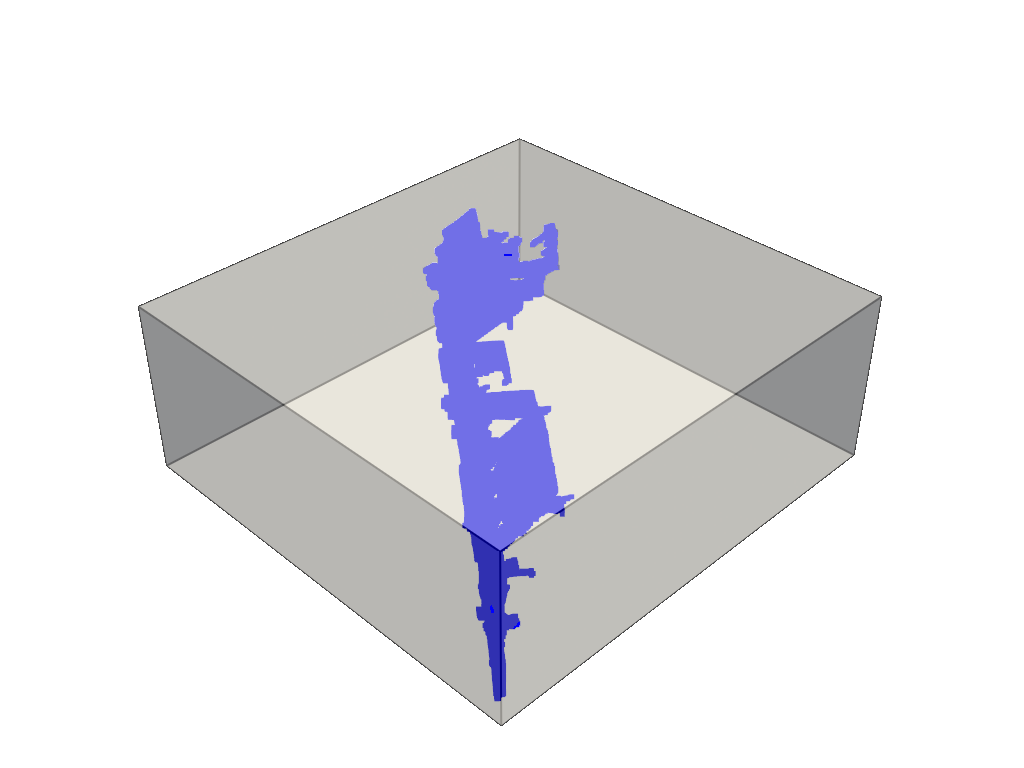

In [11]:
#------------------------------------------------------------------------------------------<Plot both>--------------------||
plotter = pv.Plotter()
plotter.add_mesh(pointCloudMesh, color="blue", point_size=5)
plotter.add_mesh(cuboid, color="white", opacity=0.5, show_edges=True, line_width=2)
plotter.show()

In [12]:
cuboid.save("InputOutput/boundingCuboid.ply")

### **2.1 Contructing oriented cuboid or LOD1**
- Perform PCA on the point cloud to determine its main orientation
- Align the point cloud along the principal directions
- Compute a bounding box in this rotated space
- Transform the box back to its original orientation.

In [13]:
import pyvista as pv
import numpy as np
import os
import warnings
from scipy.spatial import ConvexHull

warnings.filterwarnings("ignore")

In [14]:
#------------------------------------------------------------------------------------------<Load PLY>---------------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    points = np.array(cloud.points)
    return points

plyFile = "InputOutput/Building_2_Label2.ply"
pointCloud = loadPC(plyFile)

pointCloudMesh = pv.PolyData(pointCloud)

In [15]:
#------------------------------------------------------------------------------------------<Oriented bounding box>--------||
def orientedBoundingBox(points):    
    #--------------------------------------------------------------------------------------<PCA to find main orientation>-||
    mean = np.mean(points, axis=0)
    centeredPoints = points - mean
    covMatx = np.cov(centeredPoints, rowvar=False)
    egVals, egVecs = np.linalg.eigh(covMatx)  #Eigen value decomposition
    
    order = np.argsort(-egVals) # Sorting in descending order
    egVecs = egVecs[:, order]

    rotatedPts = centeredPoints @ egVecs #Rotating to PCA's direction

    #--------------------------------------------------------------------------------------<Construct cuboid>-------------||
    minCorner = np.min(rotatedPts, axis=0) #Returns 3 pts
    maxCorner = np.max(rotatedPts, axis=0)

    vertices = np.array([
        [minCorner[0], minCorner[1], minCorner[2]],
        [maxCorner[0], minCorner[1], minCorner[2]],
        [maxCorner[0], maxCorner[1], minCorner[2]],
        [minCorner[0], maxCorner[1], minCorner[2]],
        [minCorner[0], minCorner[1], maxCorner[2]],
        [maxCorner[0], minCorner[1], maxCorner[2]],
        [maxCorner[0], maxCorner[1], maxCorner[2]],
        [minCorner[0], maxCorner[1], maxCorner[2]]
    ])

    vertices = (vertices @ egVecs.T) + mean #Transform vertices to original space

    faces = np.array([
        [4, 0, 1, 2, 3],
        [4, 4, 5, 6, 7],
        [4, 0, 1, 5, 4],
        [4, 1, 2, 6, 5],
        [4, 2, 3, 7, 6],
        [4, 3, 0, 4, 7]
    ])

    obbMesh = pv.PolyData(vertices, faces)
    return obbMesh

obb = orientedBoundingBox(pointCloud)

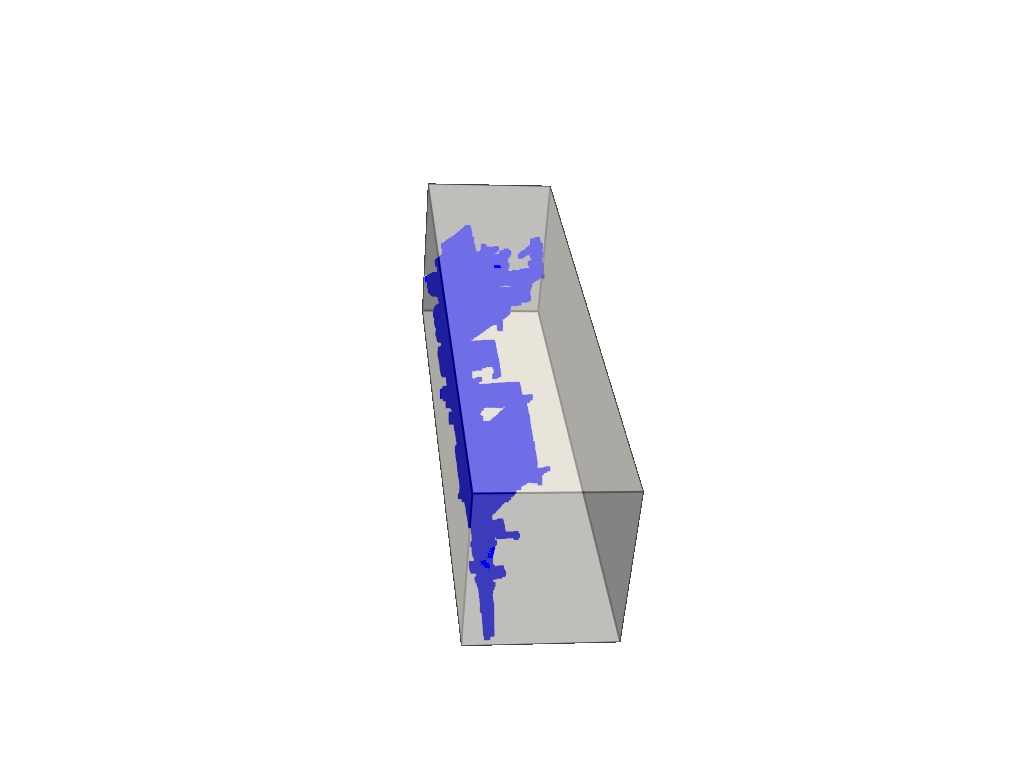

In [16]:
#------------------------------------------------------------------------------------------<Plot>-------------------------||
plotter = pv.Plotter()
plotter.add_mesh(pointCloudMesh, color="blue", point_size=5)  # Point cloud
plotter.add_mesh(obb, color="white", opacity=0.5, show_edges=True, edge_color="black", line_width=2)
plotter.show()

In [17]:
obb.save("InputOutput/orientedBoundingBox.ply")

#### 2.2 Iteratively building cuboids

In [18]:
import pyvista as pv
import numpy as np
import os
import warnings
import glob

from scipy.spatial import ConvexHull

warnings.filterwarnings("ignore")

In [19]:
#------------------------------------------------------------------------------------------<Oriented bounding box>--------||
def orientedBoundingBox(points):    
    #--------------------------------------------------------------------------------------<PCA to find main orientation>-||
    mean = np.mean(points, axis=0)
    centeredPoints = points - mean
    covMatx = np.cov(centeredPoints, rowvar=False)
    egVals, egVecs = np.linalg.eigh(covMatx)  #Eigen value decomposition
    
    order = np.argsort(-egVals) # Sorting in descending order
    egVecs = egVecs[:, order]

    rotatedPts = centeredPoints @ egVecs #Rotating to PCA's direction

    #--------------------------------------------------------------------------------------<Construct cuboid>-------------||
    minCorner = np.min(rotatedPts, axis=0) #Returns 3 pts
    maxCorner = np.max(rotatedPts, axis=0)

    vertices = np.array([
        [minCorner[0], minCorner[1], minCorner[2]],
        [maxCorner[0], minCorner[1], minCorner[2]],
        [maxCorner[0], maxCorner[1], minCorner[2]],
        [minCorner[0], maxCorner[1], minCorner[2]],
        [minCorner[0], minCorner[1], maxCorner[2]],
        [maxCorner[0], minCorner[1], maxCorner[2]],
        [maxCorner[0], maxCorner[1], maxCorner[2]],
        [minCorner[0], maxCorner[1], maxCorner[2]]
    ])

    vertices = (vertices @ egVecs.T) + mean #Transform vertices to original space

    faces = np.array([
        [4, 0, 1, 2, 3],
        [4, 4, 5, 6, 7],
        [4, 0, 1, 5, 4],
        [4, 1, 2, 6, 5],
        [4, 2, 3, 7, 6],
        [4, 3, 0, 4, 7]
    ])

    obbMesh = pv.PolyData(vertices, faces)
    return obbMesh

In [20]:
#------------------------------------------------------------------------------------------<Load PLY Files>---------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    points = np.array(cloud.points)
    return points

def processPLYFiles(inputDir, outputDir):
    for fileName in os.listdir(inputDir):
        if fileName.endswith(".ply"):
            filePath = os.path.join(inputDir, fileName)
            points = loadPC(filePath)
            
            obbMesh = orientedBoundingBox(points)
            
            outputFilePath = os.path.join(outputDir, f"OBB_{fileName}")
            obbMesh.save(outputFilePath)
            print(f"Processed: {fileName} -> Saved: {outputFilePath}")

In [21]:
#------------------------------------------------------------------------------------------<Main Execution>-------------||
#inputDir = "/mnt/d/Krishna/Research/DigitalTwins/Misc/GeoTile/Extracted"
inputDir = "ParisLille/BuildingsPLY" 
outputDir = "InputOutput/OutputMeshes"
processPLYFiles(inputDir, outputDir)

Processed: class #16.ply -> Saved: InputOutput/OutputMeshes/OBB_class #16.ply
Processed: class #197.ply -> Saved: InputOutput/OutputMeshes/OBB_class #197.ply
Processed: class #2.ply -> Saved: InputOutput/OutputMeshes/OBB_class #2.ply
Processed: class #4.ply -> Saved: InputOutput/OutputMeshes/OBB_class #4.ply
Processed: class #5.ply -> Saved: InputOutput/OutputMeshes/OBB_class #5.ply
Processed: class #6.ply -> Saved: InputOutput/OutputMeshes/OBB_class #6.ply
Processed: class #7.ply -> Saved: InputOutput/OutputMeshes/OBB_class #7.ply
Processed: class #8.ply -> Saved: InputOutput/OutputMeshes/OBB_class #8.ply


## **3. Construction of LOD1.2**

#### 3.1 Iteratively building cuboids **(using convexhull)**

In [21]:
import pyvista as pv
import numpy as np
import warnings
import os
from scipy.spatial import ConvexHull

warnings.filterwarnings("ignore")

In [22]:
#------------------------------------------------------------------------------------------<Footprint & Extrude>----------||
def generateLOD12Extrusion(points):
    minZ = np.min(points[:, 2])
    maxZ = np.max(points[:, 2])
    height = maxZ - minZ

    # Project to XY plane
    footprint2D = points[:, :2]
    hull = ConvexHull(footprint2D) #USING CONVEX HULLLL!!!!!!!!!
    footprint = footprint2D[hull.vertices]
    nPts = len(footprint)

    # Create 3D footprints
    base3D = np.column_stack((footprint, np.full(nPts, minZ)))
    top3D = np.column_stack((footprint, np.full(nPts, maxZ)))

    # Create side faces (extrusion)
    faces = []
    for i in range(nPts):
        i_next = (i + 1) % nPts
        faces.append([4, i, i_next, nPts + i_next, nPts + i])

    # Merge base and top
    allVerts = np.vstack((base3D, top3D))

    # Add base and top faces (reversed order for correct normals)
    faces.append([nPts] + list(reversed(range(nPts))))                   # Bottom face
    faces.append([nPts] + list(range(nPts, 2 * nPts)))                   # Top face

    faces = np.hstack(faces)  # Flatten list
    mesh = pv.PolyData(allVerts, faces)

    return mesh

In [23]:
#------------------------------------------------------------------------------------------<Load PLY Files>---------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    points = np.array(cloud.points)
    return points

def processPLYFiles(inputDir, outputDir):
   for fileName in os.listdir(inputDir):
        if fileName.endswith(".ply"):
            filePath = os.path.join(inputDir, fileName)
            points = loadPC(filePath) #THISSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
            
            lod12Mesh = generateLOD12Extrusion(points)
            lod12Mesh = lod12Mesh.triangulate()  # Convert quads/ngons to triangles
            
            outputFilePath = os.path.join(outputDir, f"LOD12_{fileName}")
            lod12Mesh.save(outputFilePath)
            print(f"Processed: {fileName} -> Saved: {outputFilePath}")

#------------------------------------------------------------------------------------------<Main Execution>-------------||
#inputDir = "/mnt/d/Krishna/Research/DigitalTwins/Misc/GeoTile/Extracted"
inputDir = "ParisLille/BuildingsPLY" 
outputDir = "InputOutput/LOD12_Meshes_Convexhull"
processPLYFiles(inputDir, outputDir)

Processed: class #16.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #16.ply
Processed: class #197.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #197.ply
Processed: class #2.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #2.ply
Processed: class #4.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #4.ply
Processed: class #5.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #5.ply
Processed: class #6.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #6.ply
Processed: class #7.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #7.ply
Processed: class #8.ply -> Saved: InputOutput/LOD12_Meshes/LOD12_class #8.ply


#### 3.2 Iteratively building cuboids **(using concavehull/ alpha shape)**

In [ ]:
import pyvista as pv
import numpy as np
import warnings
import os
from scipy.spatial import KDTree

warnings.filterwarnings("ignore")

#------------------------------------------------------------------------------------------<Concave Hull Function>--------||
def computeConcaveHull(points2D, k=10):
    assert len(points2D) >= 3, "Need at least 3 points"

    points = points2D.tolist()
    hull = []

    # Start from the left-most point
    first = min(points, key=lambda x: x[0])
    hull.append(first)
    points.remove(first)

    current = first
    prevAngle = 0

    while True:
        k = min(k, len(points))  # Adjust k dynamically
        tree = KDTree(points)
        _, idxs = tree.query(current, k=k)

        candidates = [points[i] for i in idxs]

        # Compute angle w.r.t previous segment
        def angle(p):
            dx, dy = p[0] - current[0], p[1] - current[1]
            theta = np.arctan2(dy, dx) - prevAngle
            return theta % (2 * np.pi)

        candidates = sorted(candidates, key=angle)

        for nextPt in candidates:
            if nextPt == first:
                hull.append(first)
                return np.array(hull)
            if nextPt not in hull:
                hull.append(nextPt)
                points.remove(nextPt)
                prevAngle = np.arctan2(nextPt[1] - current[1], nextPt[0] - current[0])
                current = nextPt
                break

    return np.array(hull)

#------------------------------------------------------------------------------------------<Footprint & Extrude>----------||
def generateLOD12Extrusion(points):
    minZ = np.min(points[:, 2])
    maxZ = np.max(points[:, 2])
    height = maxZ - minZ

    # Project to XY plane
    footprint2D = points[:, :2]
    footprint = computeConcaveHull(footprint2D, k=10)
    nPts = len(footprint)

    # Create 3D footprints
    base3D = np.column_stack((footprint, np.full(nPts, minZ)))
    top3D = np.column_stack((footprint, np.full(nPts, maxZ)))

    # Create side faces (extrusion)
    faces = []
    for i in range(nPts):
        i_next = (i + 1) % nPts
        faces.append([4, i, i_next, nPts + i_next, nPts + i])

    # Merge base and top
    allVerts = np.vstack((base3D, top3D))

    # Add base and top faces
    faces.append([nPts] + list(reversed(range(nPts))))                 # Bottom face
    faces.append([nPts] + list(range(nPts, 2 * nPts)))                 # Top face

    faces = np.hstack(faces)
    mesh = pv.PolyData(allVerts, faces)

    return mesh

#------------------------------------------------------------------------------------------<Load PLY Files>---------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    points = np.array(cloud.points)
    return points

def processPLYFiles(inputDir, outputDir):
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)
    
    for fileName in os.listdir(inputDir):
        if fileName.endswith(".ply"):
            filePath = os.path.join(inputDir, fileName)
            points = loadPC(filePath)
            
            lod12Mesh = generateLOD12Extrusion(points)
            lod12Mesh = lod12Mesh.triangulate()
            
            outputFilePath = os.path.join(outputDir, f"LOD12_{fileName}")
            lod12Mesh.save(outputFilePath)
            print(f"Processed: {fileName} -> Saved: {outputFilePath}")

#------------------------------------------------------------------------------------------<Main Execution>--------------||
inputDir = "ParisLille/BuildingsPLY" 
outputDir = "InputOutput/LOD12_Meshes_Concave"
processPLYFiles(inputDir, outputDir)

In [ ]:
print("Test")